# metrics

In [1]:
import os
import numpy as np

scenes = [
    "basketball", "boxes", "football", "juggle", "softball", "tennis"]
for scene in scenes:
    results_dir = f"/restricted/projectnb/cs599dg/mwakeham/trajectory_examples_trajan_results/{scene}"

    summary_path = os.path.join(results_dir, "overall_summary.npy")
    overall_summary = np.load(summary_path, allow_pickle=True).item()
    
    example_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    example_dirs.sort()

    all_example_jaccards = []  # Mean jaccard for each example
    all_example_mean_diffs = []  # Mean viewpoint difference for each example
    all_example_std_diffs = []  # SD of viewpoint differences for each example

    for example_dir in example_dirs:
        example_path = os.path.join(results_dir, example_dir)
        
        metrics_files = [f for f in os.listdir(example_path) if f.startswith('trajan_metrics')]
        if not metrics_files:
            continue
            
        view_jaccards = []
        
        for metrics_file in sorted(metrics_files):
            metrics_path = os.path.join(example_path, metrics_file)
            metrics_data = np.load(metrics_path, allow_pickle=True)
            jaccard = metrics_data['average_jaccard']
            view_jaccards.append(jaccard)

        example_mean_jaccard = np.mean(view_jaccards)
        all_example_jaccards.append(example_mean_jaccard)

        pairwise_diffs = []
        for i in range(len(view_jaccards)):
            for j in range(i+1, len(view_jaccards)):
                diff = abs(view_jaccards[i] - view_jaccards[j])
                pairwise_diffs.append(diff)
        
        if pairwise_diffs:
            example_mean_diff = np.mean(pairwise_diffs)
            example_std_diff = np.std(pairwise_diffs)
            all_example_mean_diffs.append(example_mean_diff)
            all_example_std_diffs.append(example_std_diff)

    jaccard_mean = np.mean(all_example_jaccards)
    jaccard_sd = np.std(all_example_jaccards)
    
    viewpoint_diff_mean = np.mean(all_example_mean_diffs)
    viewpoint_diff_sd_mean = np.mean(all_example_std_diffs)

    print(f"\n{scene}")
    print(f"Jaccard - Mean across examples: {jaccard_mean:.4f}")
    print(f"Jaccard - SD across examples: {jaccard_sd:.4f}")
    print(f"Viewpoint difference - Mean across examples: {viewpoint_diff_mean:.4f}")
    print(f"Viewpoint difference - Mean SD across examples: {viewpoint_diff_sd_mean:.4f}")


basketball
Jaccard - Mean across examples: 0.4831
Jaccard - SD across examples: 0.0479
Viewpoint difference - Mean across examples: 0.0470
Viewpoint difference - Mean SD across examples: 0.0272

boxes
Jaccard - Mean across examples: 0.6096
Jaccard - SD across examples: 0.0409
Viewpoint difference - Mean across examples: 0.0532
Viewpoint difference - Mean SD across examples: 0.0307

football
Jaccard - Mean across examples: 0.6778
Jaccard - SD across examples: 0.0302
Viewpoint difference - Mean across examples: 0.0543
Viewpoint difference - Mean SD across examples: 0.0304

juggle
Jaccard - Mean across examples: 0.6624
Jaccard - SD across examples: 0.0334
Viewpoint difference - Mean across examples: 0.0556
Viewpoint difference - Mean SD across examples: 0.0323

softball
Jaccard - Mean across examples: 0.5241
Jaccard - SD across examples: 0.0463
Viewpoint difference - Mean across examples: 0.0524
Viewpoint difference - Mean SD across examples: 0.0300

tennis
Jaccard - Mean across examples

# latents

Total latents: 2400
Latent shape: (8192,)
Running t-SNE with perplexity: 5
Running t-SNE with perplexity: 15
Running t-SNE with perplexity: 30
Running t-SNE with perplexity: 50


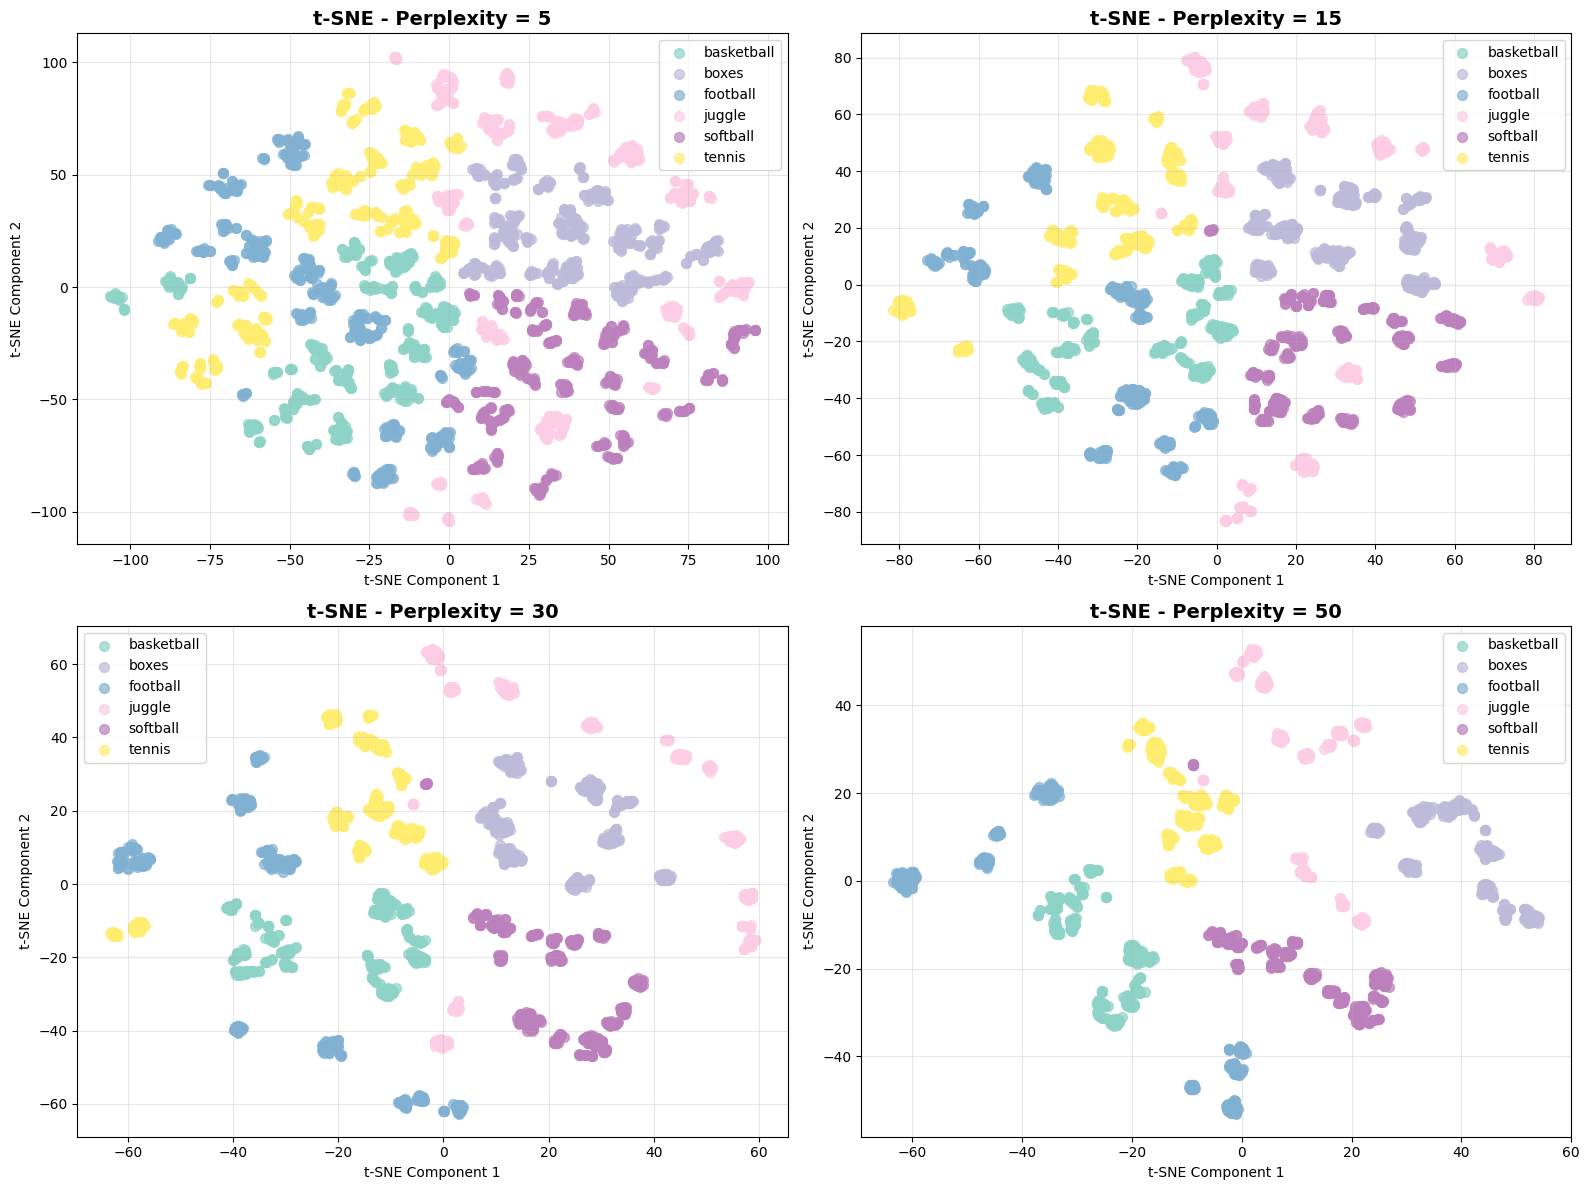

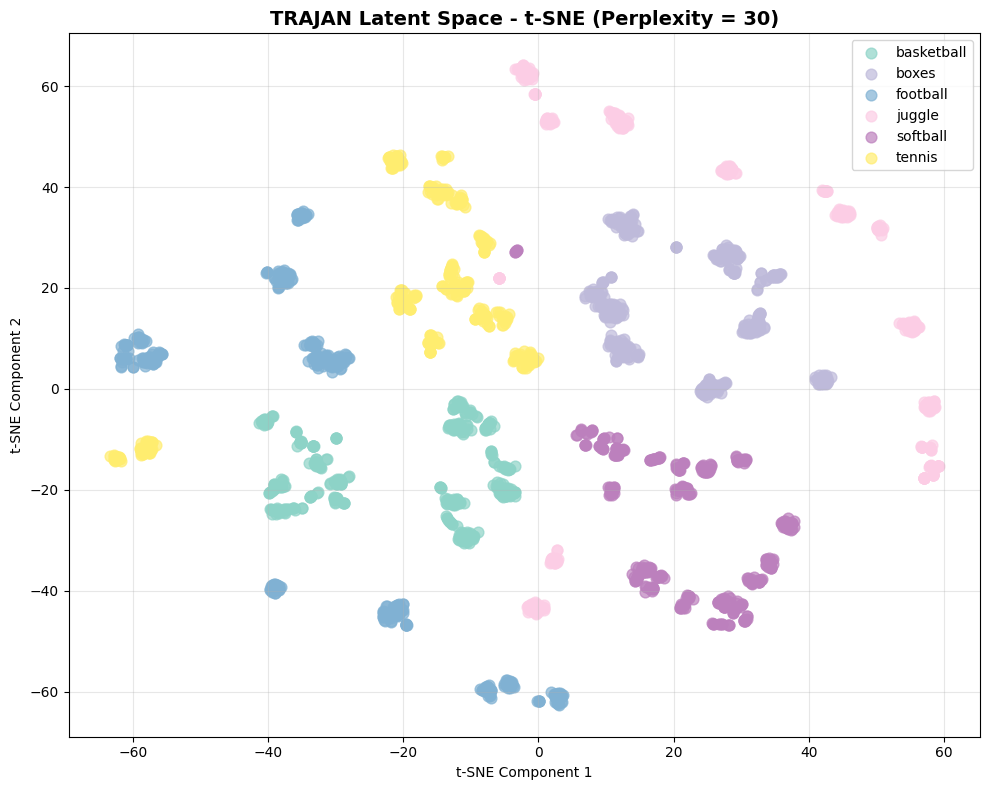

In [2]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scenes = ["basketball", "boxes", "football", "juggle", "softball", "tennis"]

all_latents = []
all_scene_labels = []
all_example_labels = []

for scene in scenes:
    results_dir = f"/restricted/projectnb/cs599dg/mwakeham/trajectory_examples_trajan_results/{scene}"
    
    example_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    example_dirs.sort()

    for example_idx, example_dir in enumerate(example_dirs):
        example_path = os.path.join(results_dir, example_dir)
        
        latent_files = [f for f in os.listdir(example_path) if f.startswith('trajan_latent')]
        
        for latent_file in sorted(latent_files):
            latent_path = os.path.join(example_path, latent_file)
            latent = np.load(latent_path)['encoded_latents']
            
            latent_flat = latent.flatten()
            
            all_latents.append(latent_flat)
            all_scene_labels.append(scene)
            all_example_labels.append(f"{scene}_{example_dir}")

all_latents = np.array(all_latents)
all_scene_labels = np.array(all_scene_labels)
all_example_labels = np.array(all_example_labels)

print(f"Total latents: {len(all_latents)}")
print(f"Latent shape: {all_latents[0].shape}")

scaler = StandardScaler()
latents_scaled = scaler.fit_transform(all_latents)

perplexities = [5, 15, 30, 50]
latents_tsne_dict = {}

for perplexity in perplexities:
    actual_perplexity = min(perplexity, len(all_latents)-1)
    print(f"Running t-SNE with perplexity: {actual_perplexity}")
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=actual_perplexity)
    latents_tsne_dict[perplexity] = tsne.fit_transform(latents_scaled)

unique_scenes = np.unique(all_scene_labels)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_scenes)))
scene_colors = dict(zip(unique_scenes, colors))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, perplexity in enumerate(perplexities):
    latents_tsne = latents_tsne_dict[perplexity]
    
    for scene in unique_scenes:
        mask = all_scene_labels == scene
        axes[i].scatter(latents_tsne[mask, 0], latents_tsne[mask, 1], 
                       label=scene, alpha=0.7, color=scene_colors[scene], s=50)
    
    axes[i].set_title(f't-SNE - Perplexity = {perplexity}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
latents_tsne = latents_tsne_dict[30]

for scene in unique_scenes:
    mask = all_scene_labels == scene
    plt.scatter(latents_tsne[mask, 0], latents_tsne[mask, 1], 
               label=scene, alpha=0.7, color=scene_colors[scene], s=60)

plt.title('TRAJAN Latent Space - t-SNE (Perplexity = 30)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()